# TODO
1. Understand code
2. Write documentation
3. Understand multi-nominal models
4. Whatever dataset used in the project - hyper tune whatever code is given and fit it to your project

# 0. Import dependencies

In [133]:
import torch
import sklearn
import numpy as np


In [134]:
from sklearn.datasets import make_classification
torch.manual_seed(123)


# 1. Working with datasets

## 1.1 Creating the datasets
Creating a toy dataset with `sklearn.make_classification()`.

In [135]:
# Make a Toy Dataset
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2)

# Change it into the Tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


In [136]:
print(f'X: {X.ndim} dim(s)\n', 'Shape of X: ', np.shape(X), '\n', X, sep='')

X: 2 dim(s)
Shape of X: torch.Size([1000, 4])
tensor([[-0.9116,  0.6875, -2.7657, -1.2134],
        [ 1.0033,  0.4338,  0.7809,  1.4395],
        [-1.3343, -2.2990,  2.2353, -2.0648],
        ...,
        [-1.0860,  0.1341, -1.9929, -1.5054],
        [-1.3421, -0.3627, -1.4583, -1.9065],
        [ 0.3800,  1.1653, -1.6072,  0.6326]])


In [137]:
print(f'y: {y.ndim} dim(s)\n', 'Shape of y: ', np.shape(y), '\n', y, sep='')

y: 1 dim(s)
Shape of y: torch.Size([1000])
tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1

## 1.2 Shuffling the datasets
Shuffling using the `torch.randperm()` function. Learn more about this function [here](https://pytorch.org/docs/stable/generated/torch.randperm.html).

Here, the first argument needs to be the size `n` in `int`. The `y.size()` simply won't work since the `torch.Tensor.size()` function returns the size as an object. We pass in the first dimension (0th) to retrieve size of the first dim in `int`. Values other than 0 won't work since this tensor only has one dim. 

In [138]:
# Shuffling data
torch.manual_seed(10)

# Creating a shuffled dataset ranging from 0 to n - 1 (999)
shuffledData = torch.randperm(y.size(0), dtype=torch.long)

# Printing a sample from our shuffled data
print(f'Sampled shuffled data:\n\n{shuffledData[:10]}')


Sampled shuffled data:

tensor([937, 859, 548, 487, 148, 190, 199, 632,  33, 714])


In [139]:
print(f'Shuffled generated data:\n\n{shuffledData}')

Shuffled generated data:

tensor([937, 859, 548, 487, 148, 190, 199, 632,  33, 714, 726, 238, 593, 108,
        226, 353, 680, 292, 312, 204, 428, 317, 164, 615, 679, 159, 886, 210,
        647, 603, 774, 360,  40, 173, 672, 744, 383, 824, 485, 811, 437, 386,
        917, 310, 977, 636, 478, 869, 358, 743, 216, 735,  99, 770, 690, 101,
        874, 509, 967, 303, 739, 273, 440, 115, 876, 104, 370, 394, 907, 182,
        402, 612, 207, 215, 469, 961,  94, 979, 459, 806, 609, 375,  66, 638,
        980,  50, 781, 135, 831, 357,  27, 451, 408, 355, 398, 367, 623, 930,
        498, 189, 585, 549, 678, 796, 978, 648, 673, 955,  45, 987, 954, 959,
        414, 643, 711, 731, 692, 950, 838, 206, 785, 244, 423,  37, 633, 875,
        291, 776, 333,  18, 936, 846, 171, 213, 730, 547, 666, 178, 488, 365,
        323, 445, 481, 535, 933, 657, 998, 832, 422, 768, 778, 343, 913, 337,
        863, 803, 121, 286, 250, 176, 305, 167, 684, 139, 299, 887, 943,  85,
        988, 667,  48, 762, 646, 510, 

We've created a list of indices that are sorted. Now mapping the shuffled indices to create a shuffled dataset.

In [140]:
X, y = X[shuffledData], y[shuffledData]

In [141]:
print(f'Shuffled X:\n\n{X}')

Shuffled X:

tensor([[-0.6446, -1.2317,  1.3100, -1.0081],
        [ 0.3220,  1.0350, -1.4523,  0.5402],
        [-0.1956,  1.4069, -2.9876, -0.1503],
        ...,
        [ 0.6935, -0.3083,  1.6959,  0.9418],
        [ 0.3839, -0.0491,  0.7077,  0.5320],
        [ 1.4912,  1.0015,  0.4825,  2.1706]])


In [142]:
print(f'Shuffled y:\n\n{y}')

Shuffled y:

tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 1., 0.,

## 1.3 Splitting the dataset into training and testing data

### 1.3.1 Shuffling data

In [143]:
# Train Test split
shuffledTrainDataMakeup = int(shuffledData.size(0) * 0.7)

shuffledTrainData = shuffledData[:shuffledTrainDataMakeup]
shuffledTestData = shuffledData[shuffledTrainDataMakeup:]


How much does the training data make up of the actual dataset.

In [144]:
print(f'Training data makeup: {shuffledTrainDataMakeup}\n\n')


Training data makeup: 700




Details of the training data.

In [145]:
print(f'Printing details of training data\n\nShape: {np.shape(shuffledTrainData)}\n\nData:\n{shuffledTrainData}')


Printing details of training data

Shape: torch.Size([700])

Data:
tensor([937, 859, 548, 487, 148, 190, 199, 632,  33, 714, 726, 238, 593, 108,
        226, 353, 680, 292, 312, 204, 428, 317, 164, 615, 679, 159, 886, 210,
        647, 603, 774, 360,  40, 173, 672, 744, 383, 824, 485, 811, 437, 386,
        917, 310, 977, 636, 478, 869, 358, 743, 216, 735,  99, 770, 690, 101,
        874, 509, 967, 303, 739, 273, 440, 115, 876, 104, 370, 394, 907, 182,
        402, 612, 207, 215, 469, 961,  94, 979, 459, 806, 609, 375,  66, 638,
        980,  50, 781, 135, 831, 357,  27, 451, 408, 355, 398, 367, 623, 930,
        498, 189, 585, 549, 678, 796, 978, 648, 673, 955,  45, 987, 954, 959,
        414, 643, 711, 731, 692, 950, 838, 206, 785, 244, 423,  37, 633, 875,
        291, 776, 333,  18, 936, 846, 171, 213, 730, 547, 666, 178, 488, 365,
        323, 445, 481, 535, 933, 657, 998, 832, 422, 768, 778, 343, 913, 337,
        863, 803, 121, 286, 250, 176, 305, 167, 684, 139, 299, 887, 943,  8

Details of the testing data.

In [146]:
print(f'Printing details of testing data\n\nShape: {np.shape(shuffledTestData)}\n\nData:\n{shuffledTestData}')


Printing details of testing data

Shape: torch.Size([300])

Data:
tensor([313, 279, 258, 960, 532, 419,  49, 777, 435, 444, 387,  23,  17, 566,
        862, 637, 728,  34,  19, 274, 331, 760, 508, 149, 893, 563, 596, 991,
        941, 565,   1, 780, 161, 461, 452, 883, 900, 569, 556, 334,  64, 839,
        122, 308, 561, 516, 567,  90, 616, 184, 396, 138, 687, 344, 338, 528,
        554, 868, 504, 976,  91, 113, 536, 490, 527, 804, 605, 854, 424, 235,
         67, 350, 601, 879, 821, 152, 621, 829, 473,  39, 825, 241, 653, 709,
        624, 472,  42, 755,  25, 622, 906, 287, 165, 125, 916, 660, 223, 446,
        691, 947, 878, 546,  68, 328, 911, 515, 434,   3, 203, 787, 181,   7,
        335, 822, 852, 289, 295, 708, 698, 826, 577, 695, 923, 788, 456, 482,
        881, 631, 132,  79, 477, 202, 404,   8, 619, 651, 506, 704, 772, 175,
        696, 985, 501,  26, 884, 511, 591, 222, 234, 194, 426, 540,  36, 608,
        146, 867, 694, 147, 284, 519, 517, 427, 830, 964, 293, 652, 948, 815

In [147]:
X_train, y_train = X[shuffledTrainData], y[shuffledTrainData]
X_test, y_test = X[shuffledTestData], y[shuffledTestData]


Printing details of shuffled training and testing data

In [148]:
X_train.shape


torch.Size([700, 4])

In [149]:
X_train


tensor([[ 0.2353, -0.6426,  1.5982,  0.2726],
        [ 1.0035,  0.3119,  1.0130,  1.4291],
        [-1.4602, -0.6789, -1.0462, -2.0992],
        ...,
        [-0.7802, -0.7168,  0.1141, -1.1525],
        [-0.0949,  1.3149, -2.6515, -0.0176],
        [-0.0274,  0.2016, -0.4271, -0.0207]])

In [150]:
X_test.shape


torch.Size([300, 4])

In [151]:
X_test


tensor([[ 0.2778, -0.7746,  1.9171,  0.3204],
        [-1.8912, -0.6178, -1.8521, -2.6959],
        [-0.9503, -2.0051,  2.2909, -1.5028],
        ...,
        [-0.6831, -0.9092,  0.6353, -1.0337],
        [-0.8343, -1.1478,  0.8468, -1.2658],
        [ 0.8807,  0.8439, -0.1949,  1.3040]])

## 1.4 Normalising data

In [152]:
mean, std = X_train.mean(dim=0), X_train.std(dim=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


## 1.5 Building a Neural Network

Importing libraries

In [153]:
import torch.nn as nn
from torch.autograd import grad


Class definition for the neural network

In [154]:
class NN():
    def __init__(self, n_features):
        self.n_features = n_features
        self.weight = torch.zeros(
            size=(n_features, 1), dtype=torch.float, requires_grad=True)
        self.bias = torch.zeros(1, dtype=torch.float, requires_grad=True)

    def forward(self, x):
        output = torch.add(torch.mm(x, self.weight), self.bias)
        return output.view(-1)


Defining our loss function. Looks oddly similar to the mean square error function.

In [155]:
def loss_fn(yHat, y):
    return torch.mean((yHat - y) ** 2)

Function to train the model returning the cost as a list.

In [156]:
def train(model, x, y, n_epoch=10, lr=0.001, seed=23, bsz=50):
    cost = []
    torch.manual_seed(seed)
    
    for i in range(n_epoch):
        shuffledData = torch.randperm(y.size(0))
        batches = torch.split(shuffledData, bsz)

        for idx in batches:
            # 1. Compute the output
            yHat = model.forward(x[idx])

            # 2. Compute the Error
            loss = loss_fn(yHat, y[idx])

            # 3. Compute the gradient
            grad_w = grad(loss, model.weight, retain_graph=True)[0]
            grad_b = grad(loss, model.bias)[0]

            # 4. Update Model Parameters
            model.weight = model.weight - lr * grad_w
            model.bias = model.bias - lr * grad_b

        # 5. Log and print the loss
        with torch.no_grad():
            yHat = model.forward(x)
            curr_loss = loss_fn(yHat, y)
            
            print('Epoch: %3d ' % (i + 1), end="")
            print('| MSE %.5f' % curr_loss)
            
            cost.append(curr_loss)

    return cost


In [157]:
model = NN(X_train.size(1))
cost = train(model, X_train, y_train, n_epoch=50)


Epoch:   1 | MSE 0.46689
Epoch:   2 | MSE 0.44403
Epoch:   3 | MSE 0.42273
Epoch:   4 | MSE 0.40286
Epoch:   5 | MSE 0.38432
Epoch:   6 | MSE 0.36700
Epoch:   7 | MSE 0.35082
Epoch:   8 | MSE 0.33568
Epoch:   9 | MSE 0.32153
Epoch:  10 | MSE 0.30829
Epoch:  11 | MSE 0.29588
Epoch:  12 | MSE 0.28426
Epoch:  13 | MSE 0.27336
Epoch:  14 | MSE 0.26316
Epoch:  15 | MSE 0.25358
Epoch:  16 | MSE 0.24460
Epoch:  17 | MSE 0.23618
Epoch:  18 | MSE 0.22826
Epoch:  19 | MSE 0.22083
Epoch:  20 | MSE 0.21386
Epoch:  21 | MSE 0.20730
Epoch:  22 | MSE 0.20114
Epoch:  23 | MSE 0.19535
Epoch:  24 | MSE 0.18991
Epoch:  25 | MSE 0.18480
Epoch:  26 | MSE 0.17999
Epoch:  27 | MSE 0.17547
Epoch:  28 | MSE 0.17123
Epoch:  29 | MSE 0.16723
Epoch:  30 | MSE 0.16347
Epoch:  31 | MSE 0.15993
Epoch:  32 | MSE 0.15660
Epoch:  33 | MSE 0.15347
Epoch:  34 | MSE 0.15052
Epoch:  35 | MSE 0.14775
Epoch:  36 | MSE 0.14514
Epoch:  37 | MSE 0.14268
Epoch:  38 | MSE 0.14037
Epoch:  39 | MSE 0.13819
Epoch:  40 | MSE 0.13614


Plotting the graph relating the epoch and error.

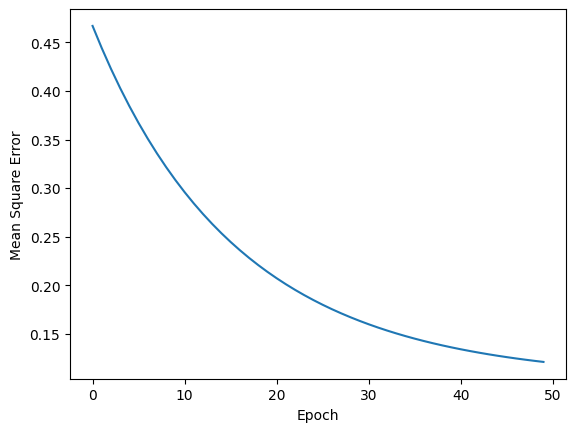

In [158]:
import matplotlib.pyplot as plt

plt.plot(range(len(cost)), cost)

plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')

plt.show()


Calculating the training and testing accuracies.

In [159]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())


In [160]:
train_pred = model.forward(X_train)
train_acc = torch.mean((torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())

test_pred = model.forward(X_test)
test_acc = torch.mean((torch.where(test_pred > 0.5, ones, zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc * 100))
print('Testing Accuracy: %.2f' % (test_acc * 100))


Training Accuracy: 86.57
Testing Accuracy: 87.67


### Model Using Pytorch

In [161]:
import torch
import sklearn
import torch.nn.functional as F


In [162]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [163]:
# Create The dataset
X, y = make_classification(n_samples=1000, n_classes=2, n_features=4)

# Normalize the Data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Array to Tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


In [164]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3,random_state=21)
print(X_train.shape)
print(X_test.shape)

torch.Size([700, 4])
torch.Size([300, 4])


In [165]:
class NeuralNetworkPyTorch(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetworkPyTorch, self).__init__()
        self.linear = nn.Linear(n_features, 1)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        out = self.linear(x)
        return out.view(-1)


Overloaded function `train()` to train the neural network built using PyTorch.

In [166]:
def train(model, x, y, n_epoch=10, lr=0.001, seed=23, bsz=50):
    cost = []
    torch.manual_seed(seed)
    
    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for i in range(n_epoch):
        shuffledData = torch.randperm(y.size(0))
        batches = torch.split(shuffledData, bsz)

        for idx in batches:
            # 1. Compute the Output
            yHat = model.forward(x[idx])

            # 2. Compute the Loss
            loss = torch.nn.functional.mse_loss(yHat, y[idx])

            # 3. Compute the Gradients
            optimizer.zero_grad()
            loss.backward()

            # 4. Update the Model Parameters
            optimizer.step()

            # model.weight=model.weight-lr*grad_w
            # model.bias=model.bias-lr*grad_b

        # 5. Log and print the Loss
        with torch.no_grad():
            yHat = model.forward(x)
            curr_loss = loss_fn(yHat, y)
            print('Epoch: %3d ' % (i + 1), end="")
            print('| MSE % .5f' % curr_loss)
            cost.append(curr_loss)

    return cost


In [167]:
n_feature = X_train.size(1)
model = NeuralNetworkPyTorch(n_features=n_feature)


In [168]:
cost = train(model, X_train, y_train, n_epoch=50)


Epoch:   1 | MSE  0.45129
Epoch:   2 | MSE  0.42124
Epoch:   3 | MSE  0.39382
Epoch:   4 | MSE  0.36880
Epoch:   5 | MSE  0.34594
Epoch:   6 | MSE  0.32505
Epoch:   7 | MSE  0.30590
Epoch:   8 | MSE  0.28836
Epoch:   9 | MSE  0.27228
Epoch:  10 | MSE  0.25751
Epoch:  11 | MSE  0.24394
Epoch:  12 | MSE  0.23146
Epoch:  13 | MSE  0.21997
Epoch:  14 | MSE  0.20938
Epoch:  15 | MSE  0.19962
Epoch:  16 | MSE  0.19060
Epoch:  17 | MSE  0.18228
Epoch:  18 | MSE  0.17458
Epoch:  19 | MSE  0.16745
Epoch:  20 | MSE  0.16085
Epoch:  21 | MSE  0.15473
Epoch:  22 | MSE  0.14905
Epoch:  23 | MSE  0.14378
Epoch:  24 | MSE  0.13888
Epoch:  25 | MSE  0.13432
Epoch:  26 | MSE  0.13008
Epoch:  27 | MSE  0.12612
Epoch:  28 | MSE  0.12244
Epoch:  29 | MSE  0.11901
Epoch:  30 | MSE  0.11581
Epoch:  31 | MSE  0.11282
Epoch:  32 | MSE  0.11003
Epoch:  33 | MSE  0.10742
Epoch:  34 | MSE  0.10497
Epoch:  35 | MSE  0.10269
Epoch:  36 | MSE  0.10055
Epoch:  37 | MSE  0.09854
Epoch:  38 | MSE  0.09666
Epoch:  39 |

[]

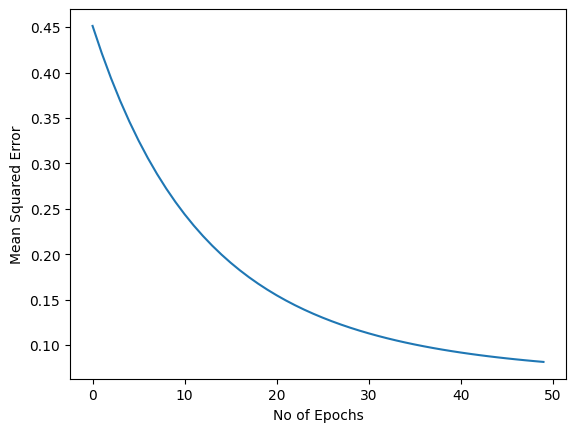

In [169]:
plt.plot(range(len(cost)), cost)
plt.xlabel('No. of Epochs')
plt.ylabel('Mean Squared Error')
plt.plot()


In [170]:
ones = torch.ones(y_train.size(0))
zero = torch.zeros(y_train.size(0))
train_pred = model.forward(X_train)

train_acc = torch.mean(
    (torch.where(train_pred > 0.5, ones, zero).int() == y_train).float())
# print(train_acc)

ones = torch.ones(y_test.size(0))
zero = torch.zeros(y_test.size(0))
test_pred = model.forward(X_test)

test_acc = torch.mean(
    (torch.where(test_pred > 0.5, ones, zero).int() == y_test).float())
print('Training Accuracy : %.2f' % train_acc)
print('Testing Accuracy: %.2f' % test_acc)


Training Accuracy : 0.93
Testing Accuracy: 0.88


### Logistic Regression

In [171]:
def train(model, x, y, n_epoch=10, lr=0.001, seed=23, bsz=50):
    cost = []
    torch.manual_seed(seed)
    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for i in range(n_epoch):
        shuffledData = torch.randperm(y.size(0))
        batches = torch.split(shuffledData, bsz)

        for idx in batches:
            # 1. Compute the Output
            yHat = model.forward(x[idx])

            # 2. Compute the Loss
            loss = torch.nn.functional.binary_cross_entropy(
                torch.sigmoid(yHat), y[idx])

            # 3. Compute the Gradients
            optimizer.zero_grad()
            loss.backward()

            # 4. Update the Model Parameters
            optimizer.step()

            # model.weight=model.weight-lr*grad_w
            # model.bias=model.bias-lr*grad_b

        # 5. Log and print the Loss
        with torch.no_grad():
            yHat = model.forward(x)
            curr_loss = loss_fn(yHat, y)
            print('Epoch : %3d ' % (i + 1), end="")
            print('| MSE % .5f' % curr_loss)
            cost.append(curr_loss)

    return cost


In [172]:
n_feature = X_train.size(1)
model = NeuralNetworkPyTorch(n_features=n_feature)


In [173]:
cost = train(model, X_train, y_train, n_epoch=50)


Epoc:   1 | MSE  0.47400
Epoc:   2 | MSE  0.46409
Epoc:   3 | MSE  0.45456
Epoc:   4 | MSE  0.44540
Epoc:   5 | MSE  0.43660
Epoc:   6 | MSE  0.42816
Epoc:   7 | MSE  0.42007
Epoc:   8 | MSE  0.41232
Epoc:   9 | MSE  0.40490
Epoc:  10 | MSE  0.39781
Epoc:  11 | MSE  0.39104
Epoc:  12 | MSE  0.38459
Epoc:  13 | MSE  0.37845
Epoc:  14 | MSE  0.37261
Epoc:  15 | MSE  0.36707
Epoc:  16 | MSE  0.36183
Epoc:  17 | MSE  0.35686
Epoc:  18 | MSE  0.35218
Epoc:  19 | MSE  0.34777
Epoc:  20 | MSE  0.34363
Epoc:  21 | MSE  0.33976
Epoc:  22 | MSE  0.33614
Epoc:  23 | MSE  0.33278
Epoc:  24 | MSE  0.32967
Epoc:  25 | MSE  0.32680
Epoc:  26 | MSE  0.32417
Epoc:  27 | MSE  0.32177
Epoc:  28 | MSE  0.31960
Epoc:  29 | MSE  0.31765
Epoc:  30 | MSE  0.31593
Epoc:  31 | MSE  0.31442
Epoc:  32 | MSE  0.31312
Epoc:  33 | MSE  0.31203
Epoc:  34 | MSE  0.31114
Epoc:  35 | MSE  0.31045
Epoc:  36 | MSE  0.30996
Epoc:  37 | MSE  0.30966
Epoc:  38 | MSE  0.30954
Epoc:  39 | MSE  0.30961
Epoc:  40 | MSE  0.30986


[]

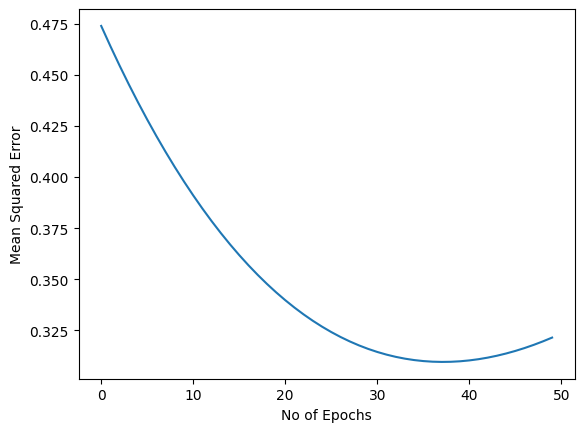

In [174]:
plt.plot(range(len(cost)), cost)
plt.xlabel('No of Epochs')
plt.ylabel('Mean Squared Error')
plt.plot()


In [175]:
ones = torch.ones(y_train.size(0))
zero = torch.zeros(y_train.size(0))
train_pred = model.forward(X_train)

train_acc = torch.mean(
    (torch.where(train_pred > 0.5, ones, zero).int() == y_train).float())
# print(train_acc)

ones = torch.ones(y_test.size(0))
zero = torch.zeros(y_test.size(0))
test_pred = model.forward(X_test)

test_acc = torch.mean(
    (torch.where(test_pred > 0.5, ones, zero).int() == y_test).float())
print('Training Accuracy : %.2f' % train_acc)
print('Testing Accuracy: %.2f' % test_acc)


Training Accuracy : 0.73
Testing Accuracy: 0.64
